# **Sesión 3:** Procesamiento de imagenes y extracción de características

## **Librerías**

In [7]:
import cv2
print("OpenCV should be 4.8.0.76 Current version:", cv2.__version__)
from typing import List
import numpy as np
import imageio
import copy
import glob
import matplotlib.pyplot as plt
from typing import Optional
from utils import *
import math
import os

OpenCV should be 4.8.0.76 Current version: 4.8.0


## **Apartado A:** Filtro Gaussiano y Detección de bordes: Sobel y Canny

El objetivo de este apartado es detectar los bordes de las imágenes de la carpeta ``data/partA-B``. Para ello, deberá seguir los siguientes pasos:

1. **Tarea A.1.** Defina el método ``gaussian_blur()`` que aplique un filtro gausiano para obtener imágenes borrosas. Siga todas las indicaciones del enunciado.
2. **Tarea A.2.** Aplique el método ``gaussian_blur()`` a todas las imágenes en ``data/partA-B``.


3. **Tarea A.3.** Defina la función ``sobel_edge_detector()`` que detecte bordes con el método Sobel. Siga todas las indicaciones del enunciado.
4. **Tarea A.4.** Aplique el método ``sobel_edge_detector()`` a todas las imágenes en ``data/partA-B``.


5. **Tarea A.5.** Defina la función ``canny_edge_detector()`` que detecte bordes con el método Canny. Siga todas las indicaciones del enunciado.
6. **Tarea A.6.** Aplique el método ``canny_edge_detector()`` a todas las imágenes en ``data/partA-B``.

### **Tarea A.1:** Defina el método ``gaussian_blur()`` que aplique un filtro gausiano para obtener imágenes borrosas.

In [ ]:
# TODO Define the method
def gaussian_blur(img: np.array, sigma: float, filter_shape: Optional[List] = None, verbose: bool = False) -> np.array:
    # If not given, compute the filter shape 
    if filter_shape == None:
        k = max(1, math.ceil(4*sigma)) # semilado del filtro (al menos 1)
        filter_l = 2*k + 1  # tamaño siempre impar
        kh, kw = filter_l, filter_l
        # El rango de sigma es [-4*sigma, 4*sigma]. Se multiplica por dos para aplicarlo en ambas direcciones (x,y)
        # Le sumamos 1 para que sea impar y tenga un centro
    else:
        # Si se pasa manualmente, nos aseguramos de que las dimensiones sean impares
        kh, kw = int(filter_shape[0]), int(filter_shape[1])
        if kh % 2 == 0:
            kh += 1
        if kw % 2 == 0:
            kw += 1
    
    # Create the filter coordinates matrices
    y, x = np.mgrid[-kh//2 : kh//2+1 , -kw//2 : kw//2+1]

    # Ej si kh = 5, kw = 5, entonces queremos los rangos [-2, -1, 0, 1, 2] tanto en x como en y. 
    # Por eso se pone +1 en el final del mgrid

    # Define the formula that goberns the filter
    formula = np.exp(-(x**2 + y**2)/(2*sigma**2)).astype(np.float32) # Ponemos tipo np.float32 para garantizar compatibilidad y precisión con OpenCV, asegurando que el kernel Gaussiano tenga el tipo de dato correcto
    gaussian_filter = formula / formula.sum() # Normalizamos el filtro para que la suma de todos sus valores sea 1 y se mantenga el brillo de la imagen
    
    # Process the image
    gb_img = cv2.filter2D(img, -1, gaussian_filter)
    
    if verbose:
        cv2.show_image(img=gb_img, img_name=f"Gaussian Blur: Sigma = {sigma}")
    
    return gaussian_filter, gb_img.astype(np.uint8) # Ponemos np.uint8 para guardar o visualizar el resultado en el mismo rango y tipo que imagen original

### **Tarea A.2.** Aplique el método ``gaussian_blur()`` a todas las imágenes en ``data``.

In [8]:
# TODO Get the gaussian blurred images using a list comprehension

# Definimos la función para cargar las imágenes
def load_images(filenames: List[str]) -> List[np.ndarray]:
    return [imageio.imread(filename) for filename in filenames]

# 1. Cargamos la imagenes
image_paths_AB = sorted(glob.glob("../data/partA-B/*.jpg"))
imgs_AB = load_images(image_paths_AB)

# 2. Definimos el valor de sigma
gauss_sigma = 2.0
gb_imgs = [gaussian_blur(img, sigma=gauss_sigma, filter_shape=None, verbose=False)[1] for img in imgs_AB]

# TODO Show images and save when needed
def show_image(img, img_name="imagen"):
    cv2.imshow(img_name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def write_image(img, output_folder, filename):
    os.makedirs(output_folder, exist_ok=True) 
    img_path = os.path.join(output_folder, filename)
    cv2.imwrite(img_path, img)

# 4. Definimos la carpeta de salida
output_folder = "../output_blurred"

# 5. Mostramos y guardamos las imágenes
for i, (orig, gb_img) in enumerate(zip(imgs_AB, gb_imgs)):
    show_image(orig, f"original_{i}")
    show_image(gb_img, f"blurred_{i}_sigma{gauss_sigma}")
    
    write_image(gb_img, output_folder, f"blurred_{i}_sigma{gauss_sigma}.jpg")

C:\Users\crist\AppData\Local\Temp\ipykernel_16540\3136817771.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea A.3:** Defina la función ``sobel_edge_detector()`` que detecte bordes con el método Sobel.

In [14]:
# TODO Define the method

def sobel_edge_detector(img: np.array, filter: np.array, gauss_sigma: float, gauss_filter_shape: Optional[List] = None, verbose: bool = False) -> np.array:
    # TODO Transform the img to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # TODO Get a blurry img to improve edge detections
    kernel, blurred = gaussian_blur(img=gray_img, sigma=gauss_sigma, filter_shape=gauss_filter_shape, verbose=verbose)
    
    # Re-scale
    blurred = blurred.astype(np.float32)/255
    
    # TODO Get vertical edges
    v_edges = cv2.filter2D(blurred, ddepth=cv2.CV_32F, kernel=filter) # Ponemos ddepth=cv2.CV_32F para que no se pierda el signo de los valores negativos y tener mayor precisión en los cálculos posteriores
    
    # TODO Transform the filter to get the orthogonal edges
    filter = filter 
    filter_T = filter.T # El filtro ortogonal se obtiene transponiendo la matriz del filtro original

    # TODO Get horizontal edges
    h_edges = cv2.filter2D(blurred, ddepth=cv2.CV_32F, kernel=filter_T) # Ponemos ddepth=cv2.CV_32F para que no se pierda el signo de los valores negativos y tener mayor precisión en los cálculos posteriores
    
    # TODO Get edges
    sobel_edges_img = np.hypot(v_edges, h_edges) # np.hypot calcula la raíz cuadrada de la suma de los cuadrados de sus argumentos, es decir, sqrt(v_edges^2 + h_edges^2)
    
    # Get edges angle
    theta = np.arctan2(h_edges, v_edges)  # np.arctan2 devuelve el ángulo en radianes entre el eje x positivo y el punto dado por las coordenadas (v_edges, h_edges)
    
    # Visualize if needed
    if verbose:
        show_image(img=sobel_edges_img, img_name="Sobel Edges")
    
    return np.squeeze(sobel_edges_img), np.squeeze(theta)

### **Tarea A.4.** Aplique el método ``sobel_edge_detector()`` a todas las imágenes en ``data``.

In [24]:
# TODO Define a sigma value
gauss_sigma = 1.4

# TODO Define the Sobel filter
sobel_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32)

# TODO Get the edges detected by Sobel using a list comprehension
sobel_edges_imgs = [sobel_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape=None, verbose=False)[0] for img in imgs_AB]

output_folder = "../output_sobel"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, sobel_img) in enumerate(zip(imgs_AB, sobel_edges_imgs)):
    # Mostrar original y bordes detectados
    show_image(orig, f"original_{i}")
    show_image(sobel_img, f"sobel_edges_{i}_sigma{gauss_sigma}")

    # Guardar imagen de bordes
    output_path = os.path.join(output_folder, f"sobel_edges_{i}_sigma{gauss_sigma}.jpg")
    cv2.imwrite(output_path, (sobel_img * 255).astype(np.uint8))

### **Tarea A.5:** Defina la función ``canny_edge_detector()`` que detecte bordes con el método Canny.

In [17]:
# TODO Define the method
def canny_edge_detector(img: np.array, sobel_filter: np.array, gauss_sigma: float, gauss_filter_shape: Optional[List] = None, verbose: bool = False):
    # TODO Call the method sobel_edge_detector()
    sobel_edges_img, theta = sobel_edge_detector(img=img, filter=sobel_filter, gauss_sigma=gauss_sigma, gauss_filter_shape=gauss_filter_shape, verbose=verbose)
    
    # TODO Use NMS to refine edges
    canny_edges_img = non_max_suppression(img=sobel_edges_img, theta=theta)
    
    if verbose:
        show_image(canny_edges_img, img_name="Canny Edges")
        
    return canny_edges_img

### **Tarea A.6.** Aplique el método ``canny_edge_detector()`` a todas las imágenes en ``data``.

In [23]:
# TODO Define Sobel filter
sobel_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32)

# TODO Define a sigma value for Gauss
gauss_sigma = 1.4

# TODO Define a Gauss filter shape
gauss_filter_shape = [8, 8]

# TODO Get the edges detected by Canny using a list comprehension
canny_edges = [canny_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape, False) for img in imgs_AB]

# Mostrar y guardar resultados
output_folder = "../output_canny"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, canny_img) in enumerate(zip(imgs_AB, canny_edges)):
    # Mostrar imágenes original y Canny
    show_image(orig, f"original_{i}")
    show_image(canny_img, f"canny_edges_{i}_sigma{gauss_sigma}")

    # Guardar resultados
    out_path = os.path.join(output_folder, f"canny_edges_{i}_sigma{gauss_sigma}.jpg")
    cv2.imwrite(out_path, canny_img)


### **Pregunta A.1:** Añada ruido a las imágenes de la carpeta ``data``. Compare los resultados que obtiene al aplicar su filtro Sobel con y sin filtro Gausiano.

#### PREGUNTAR CUÁL ES MEJOR

#### VERSIÓN 1: Sigma = 0 usando misma función

In [25]:
# TODO Homework

# Función para añadir ruido gaussiano
def add_gaussian_noise(img, mean, std):
    noise = np.random.normal(mean, std, img.shape)
    noisy = img.astype(np.float32) + noise
    # Aseguramos que los valores queden en [0, 255]
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# Crear imágenes con ruido
mean = 0
std_noise = 25
noisy_imgs = [add_gaussian_noise(img, mean, std_noise) for img in imgs_AB]

# Definir el filtro Sobel
sobel_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32)

# Aplicar Sobel con y sin filtro Gaussiano
gauss_sigma = 1.4
gauss_filter_shape = None  # que se calcule automáticamente

# Con filtro Gaussiano
sobel_with_gauss = [sobel_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape, verbose=False)[0] for img in noisy_imgs]

# Sin filtro Gaussiano (sigma = 0)
sobel_no_gauss = [sobel_edge_detector(img, sobel_filter, 0.0001, None, verbose=False)[0] for img in noisy_imgs]

# Mostrar y guardar resultados
output_folder = "../output_sobel_noise"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, noisy, sobel_g, sobel_ng) in enumerate(zip(imgs_AB, noisy_imgs, sobel_with_gauss, sobel_no_gauss)):
    show_image(orig, f"Original_{i}")
    show_image(noisy, f"Noisy_{i}")
    show_image(sobel_g, f"Sobel_with_Gauss_{i}")
    show_image(sobel_ng, f"Sobel_no_Gauss_{i}")

    # Guardar resultados
    cv2.imwrite(os.path.join(output_folder, f"noisy_{i}.jpg"), noisy)
    cv2.imwrite(os.path.join(output_folder, f"sobel_with_gauss_{i}.jpg"), (sobel_g * 255).astype(np.uint8))
    cv2.imwrite(os.path.join(output_folder, f"sobel_no_gauss_{i}.jpg"), (sobel_ng * 255).astype(np.uint8))


#### VERSIÓN 2: Cambiando la función oara no aplicar el filtro

In [26]:
def sobel_no_blur(img: np.array, filter: np.array, verbose: bool = False) -> np.array:
    # Transform the img to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    # Get vertical edges
    v_edges = cv2.filter2D(gray_img, ddepth=cv2.CV_32F, kernel=filter)
    # Transform the filter to get the orthogonal edges
    filter_t = filter.T
    # Get horizontal edges
    h_edges = cv2.filter2D(gray_img, ddepth=cv2.CV_32F, kernel=filter_t)
    # Get edges
    sobel_edges_img = np.clip(np.hypot(v_edges, h_edges), 0.0, 1.0)
    # Get edges angle
    theta = np.arctan2(h_edges, v_edges)
    # Visualize if needed
    if verbose:
        show_image(img=sobel_edges_img, img_name="Sobel Edges")
    return np.squeeze(sobel_edges_img), np.squeeze(theta)


# Función para añadir ruido gaussiano
def add_gaussian_noise(img, mean, std):
    noise = np.random.normal(mean, std, img.shape)
    noisy = img.astype(np.float32) + noise
    # Aseguramos que los valores queden en [0, 255]
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

# Crear imágenes con ruido
mean = 0
std_noise = 25
noisy_imgs = [add_gaussian_noise(img, mean, std_noise) for img in imgs_AB]

# Definir el filtro Sobel
sobel_filter = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32)

# Aplicar Sobel con y sin filtro Gaussiano
gauss_sigma = 1.4
gauss_filter_shape = None  # que se calcule automáticamente

# Con filtro Gaussiano
sobel_with_gauss = [sobel_edge_detector(img, sobel_filter, gauss_sigma, gauss_filter_shape, verbose=False)[0] for img in noisy_imgs]

# Sin filtro Gaussiano (sigma = 0)
sobel_no_gauss = [sobel_no_blur(img, sobel_filter, verbose=False)[0] for img in noisy_imgs]

# Mostrar y guardar resultados
output_folder = "../output_sobel_noise"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, noisy, sobel_g, sobel_ng) in enumerate(zip(imgs_AB, noisy_imgs, sobel_with_gauss, sobel_no_gauss)):
    show_image(orig, f"Original_{i}")
    show_image(noisy, f"Noisy_{i}")
    show_image(sobel_g, f"Sobel_with_Gauss_{i}")
    show_image(sobel_ng, f"Sobel_no_Gauss_{i}")

    # Guardar resultados
    cv2.imwrite(os.path.join(output_folder, f"noisy_{i}.jpg"), noisy)
    cv2.imwrite(os.path.join(output_folder, f"sobel_with_gauss_{i}.jpg"), (sobel_g * 255).astype(np.uint8))
    cv2.imwrite(os.path.join(output_folder, f"sobel_no_gauss_{i}.jpg"), (sobel_ng * 255).astype(np.uint8))



##### Este apartado busca analizar cómo afecta el ruido a la detección de bordes y mostrar la importancia del suavizado Gaussiano previo al filtro Sobel. Sin suavizado, el Sobel amplifica el ruido y genera bordes falsos e irregulares, ya que interpreta las pequeñas variaciones del ruido como cambios de intensidad reales. Al aplicar un filtro Gaussiano antes del Sobel, se reduce el ruido y los bordes aparecen más definidos, continuos y limpios, conservando solo las estructuras relevantes de la imagen. Sin embargo, este proceso introduce un compromiso entre suavizado y precisión: un valor alto de 𝜎 elimina más ruido pero también difumina detalles finos mientras que uno bajo mantiene el detalle pero deja pasar más ruido. Por tanto, el valor de 𝜎 debe elegirse cuidadosamente para equilibrar la reducción del ruido y la preservación de los bordes reales. En conclusión, el suavizado Gaussiano es un paso esencial para mejorar la robustez y estabilidad del filtro Sobel frente al ruido, garantizando bordes más coherentes y representativos de la estructura de la escena.

### **Pregunta A.2:** Utilice la librería ``scikit-image`` y compare el efecto de los filtros Sobel, Canny y Prewitt sobre las imágenes de la carpeta ``data``. ¿Qué diferencias observa entre los filtros? ¿Puede obtener alguna conclusión y/o patrón?

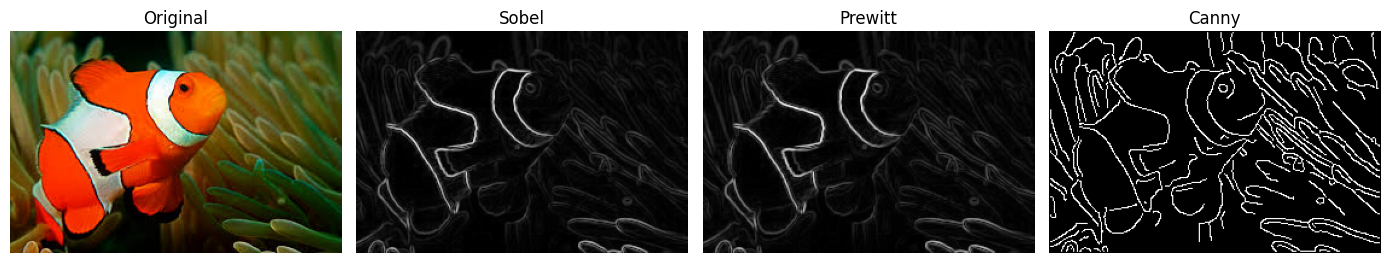

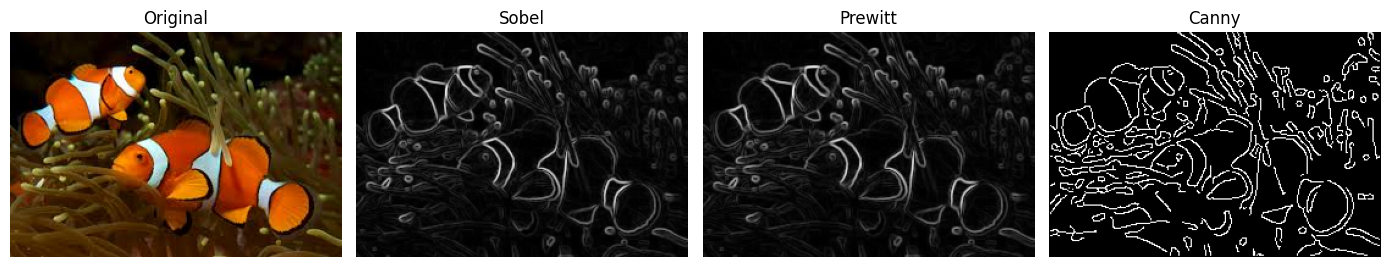

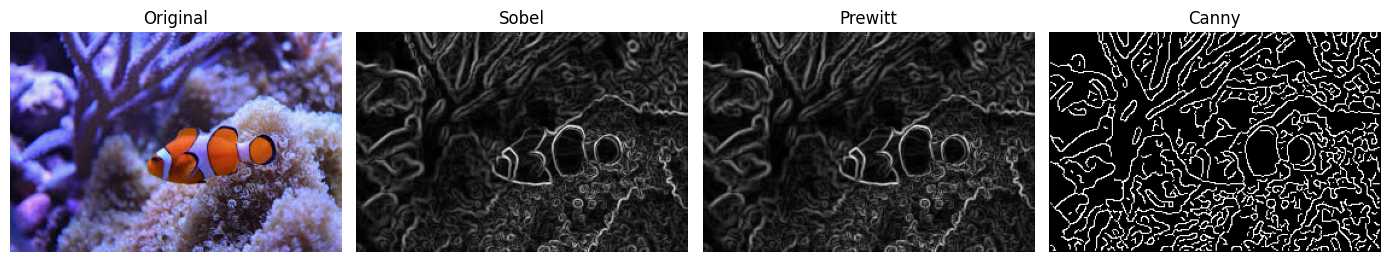

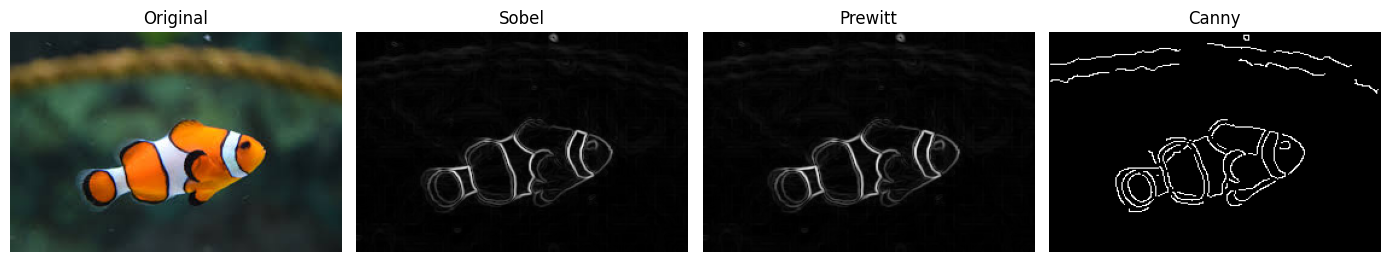

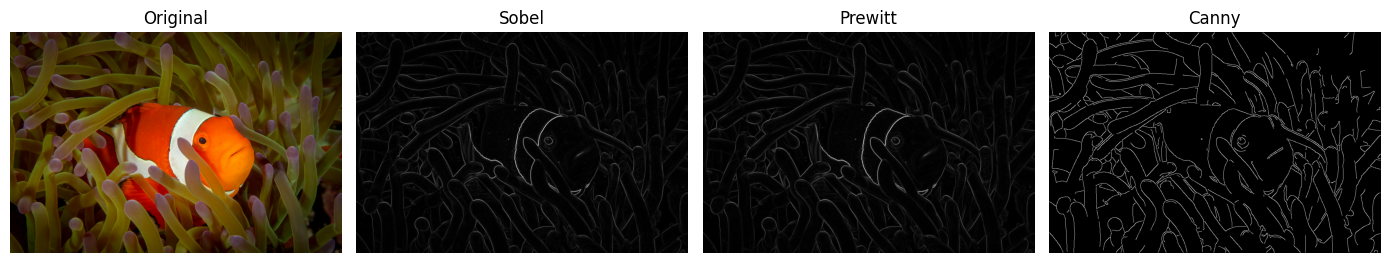

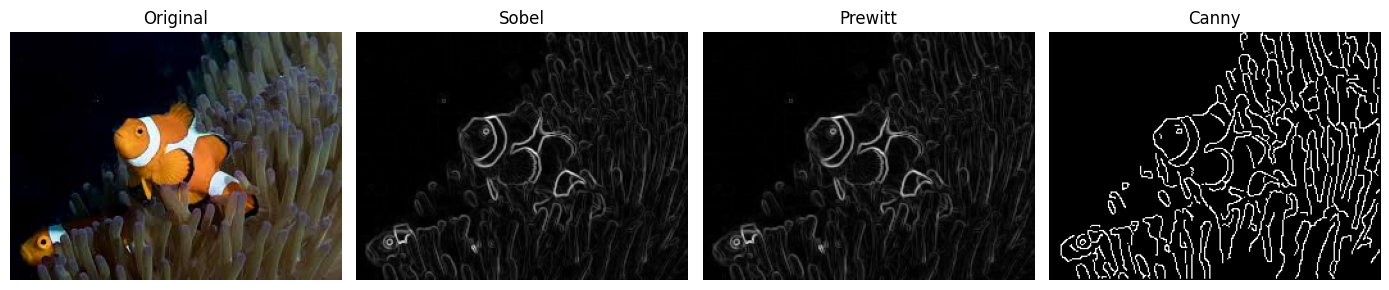

In [ ]:
# TODO Homework

from skimage import filters, feature, color

# Convertir a escala de grises
gray_imgs = []
for img in imgs_AB:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    gray_imgs.append(gray_img)

# Aplicar los tres filtros de scikit-image
sobel_edges = [filters.sobel(img) for img in gray_imgs]
prewitt_edges = [filters.prewitt(img) for img in gray_imgs]
canny_edges = [feature.canny(img, sigma=1.4) for img in gray_imgs]

# Mostrar resultados comparativos
output_folder = "../output_comparison"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, sobel_img, prewitt_img, canny_img) in enumerate(zip(imgs_AB, sobel_edges, prewitt_edges, canny_edges)):
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    axes[0].imshow(orig)
    axes[0].set_title("Original")
    axes[1].imshow(sobel_img, cmap="gray")
    axes[1].set_title("Sobel")
    axes[2].imshow(prewitt_img, cmap="gray")
    axes[2].set_title("Prewitt")
    axes[3].imshow(canny_img, cmap="gray")
    axes[3].set_title("Canny")
    for ax in axes: ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Guardar resultados
    plt.imsave(os.path.join(output_folder, f"sobel_sk_{i}.jpg"), sobel_img, cmap="gray")
    plt.imsave(os.path.join(output_folder, f"prewitt_sk_{i}.jpg"), prewitt_img, cmap="gray")
    plt.imsave(os.path.join(output_folder, f"canny_sk_{i}.jpg"), canny_img, cmap="gray")


##### En este apartado se busca comparar el comportamiento de los filtros Sobel, Prewitt y Canny al detectar bordes en una imagen.Los filtros Sobel y Prewitt calculan el gradiente de intensidad. Sobel usa una ponderación mayor en el centro del kernel lo que genera bordes más suaves y menos sensibles al ruido, mientras que Prewitt produce bordes más marcados pero con mayor ruido. Por otro lado, Canny aplica un proceso más completo que incluye suavizado Gaussiano, supresión de no máximos y umbral con histéresis obteniendo bordes más finos, continuos y precisos. En general, Sobel ofrece un buen equilibrio entre suavizado y sensibilidad, Prewitt es más simple pero menos robusto y Canny proporciona los bordes más limpios y estables, siendo el método más fiable para la detección de bordes en imágenes reales.

## **Apartado B:** Operadores Morfológicos

Para resolver este partado, deberá seguir los siguientes pasos:

1. **Tarea B.1.** Defina el método ``binarize()`` para binarizar imágenes.
2. **Tarea B.2.** Defina el método ``custom_dilate()``.
3. **Tarea B.3.** Defina el método ``custom_erode()``.
4. **Pregunta B.1** Aplique los métodos ``custom_dilate()`` y ``custom_erode()`` a todas las imágenes de la carpeta ``data``.


### **Tarea B.1.** Defina el método ``binarize()`` para binarizar imágenes.

In [28]:
# TODO Homework: define the binarization method
def binarize(img: np.array, threshold: int = 127):
    _, binary_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return binary_img

##### La función binarize() convierte una imagen en una versión binaria (blanco y negro) aplicando un umbral: los píxeles con valor superior a threshold se ponen a 255 (blanco) y los inferiores a 0 (negro).Esto se realiza con cv2.threshold(), lo que permite preparar la imagen para aplicar operaciones morfológicas como erosión o dilatación

### **Tarea B.2.** Defina el método ``custom_dilate()``

In [32]:
# TODO Homework: define the dilation method
def custom_dilate(img: np.array) -> np.array:

    # TODO pad the original image so it can keep dimensions after processing
    padded = np.pad(img, pad_width=1, mode='constant', constant_values=0)

    # TODO get img shape
    height = img.shape[0]
    width = img.shape[1]

    # TODO Create an element with the same dimensions as the padded img
    dilated = np.zeros_like(padded)

    for j in range(1, height + 1):
        for i in range(1, width + 1):
            # TODO Add logic to the operation
            dilated[j, i] = np.max(padded[j-1:j+2, i-1:i+2])

    # TODO Select the region of interest (ROI)
    dilated = dilated[1:height+1, 1:width+1]

    return dilated.astype(np.uint8)

##### La función custom_dilate() realiza una dilatación morfológica sobre una imagen binaria. Primero añade un borde negro (padding) para evitar perder información en los bordes, luego recorre cada píxel y examina su vecindad 3×3. Si algún píxel del vecindario es blanco (255), el píxel central también se vuelve blanco, haciendo que las regiones blancas se expandan. Finalmente, se elimina el padding para devolver la imagen dilatada con el mismo tamaño original.

### **Tarea B.3.** Defina el método ``custom_erode()``

In [35]:
# TODO Homework: define the erotion method
def custom_erode(img: np.array) -> np.array:
    # pad the original image so it can keep dimensions after processing
    padded = np.pad(img, pad_width=1, mode='constant', constant_values=0)

    # get img shape
    height, width = img.shape

    # Create an element with the same dimensions as the padded img
    eroded = np.zeros_like(padded)

    for j in range(1, height + 1):
        for i in range(1, width + 1):
            eroded[j, i] = np.min(padded[j-1:j+2, i-1:i+2])

    # Select the region of interest (ROI)
    eroded = eroded[1:height+1, 1:width+1]

    return eroded.astype(np.uint8)

### **Pregunta B.1** Aplique los métodos ``custom_dilate()`` y ``custom_erode()`` a todas las imágenes de la carpeta ``data``.

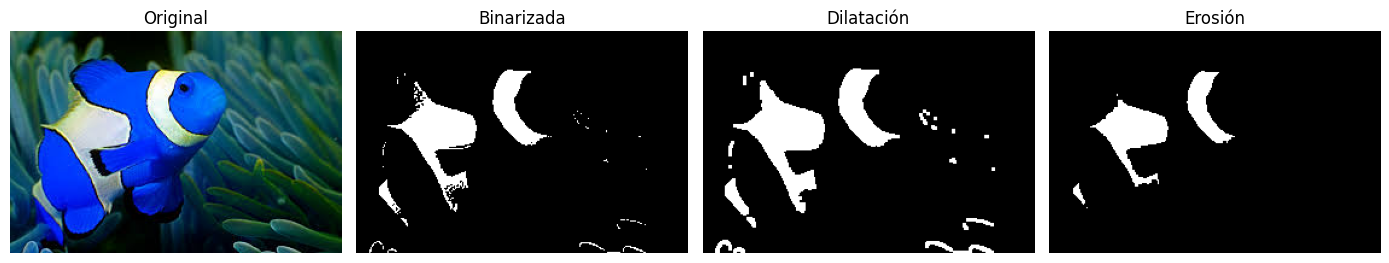

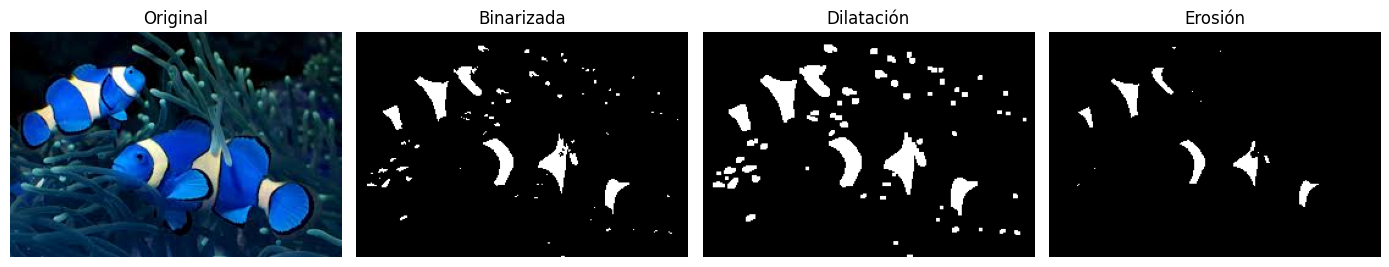

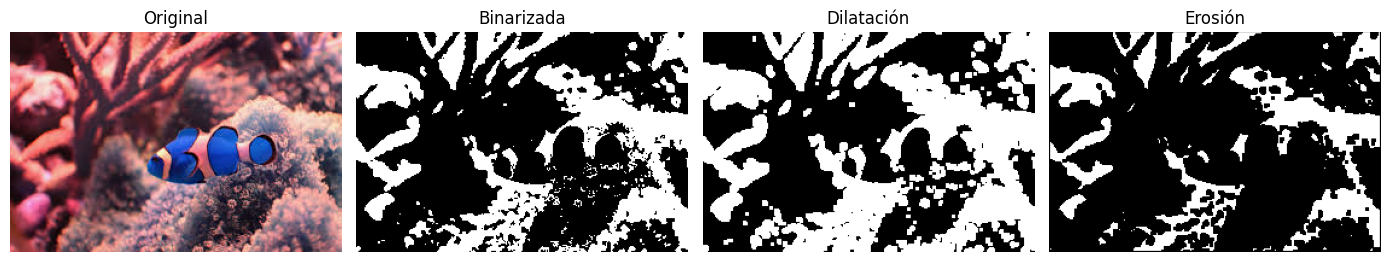

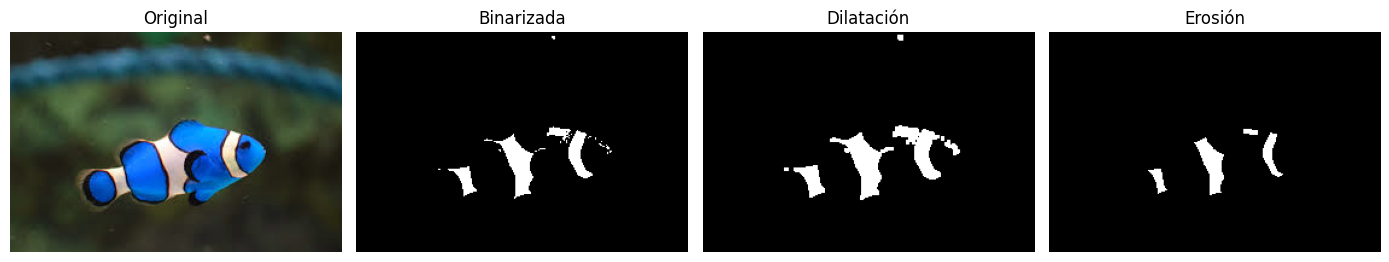

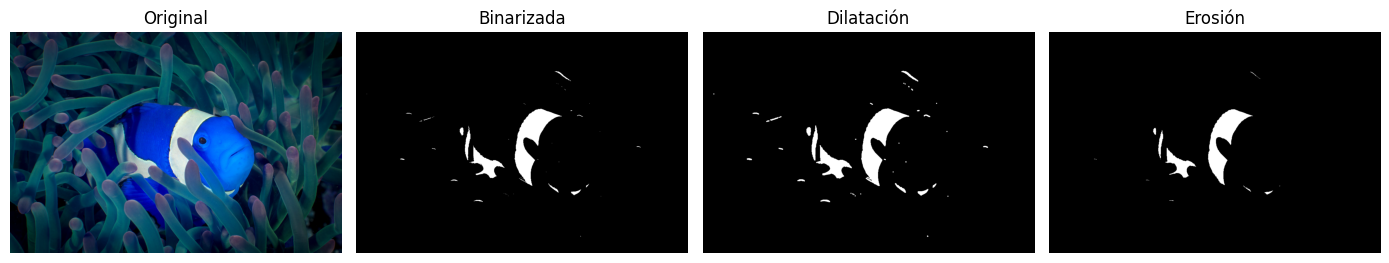

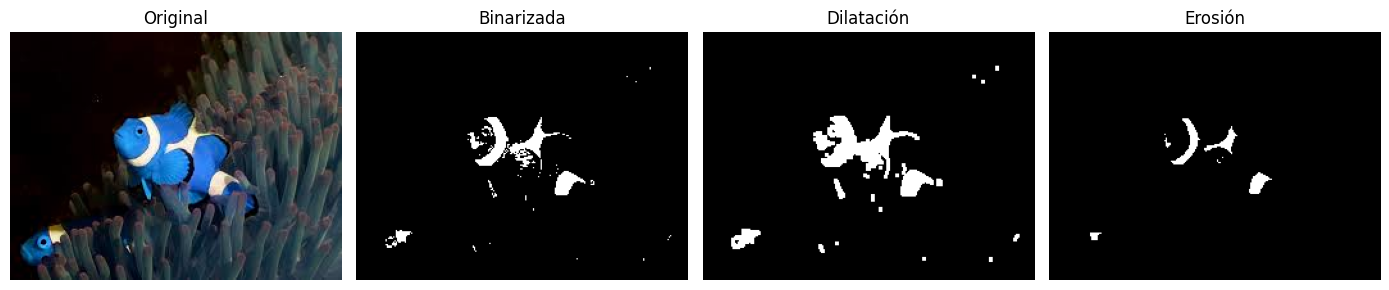

In [44]:
# TODO Homework

gray_imgs = []
for img in imgs_AB:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_imgs.append(gray_img)

binary_imgs = [binarize(img) for img in gray_imgs]

# Aplicar dilatación y erosión personalizadas
dilated_imgs = [custom_dilate(img) for img in binary_imgs]
eroded_imgs = [custom_erode(img) for img in binary_imgs]

# Mostrar y guardar resultados
output_folder = "../output_morphology"
os.makedirs(output_folder, exist_ok=True)

for i, (orig, binary, dilated, eroded) in enumerate(zip(imgs_AB, binary_imgs, dilated_imgs, eroded_imgs)):
    fig, axes = plt.subplots(1, 4, figsize=(14, 5))
    axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[1].imshow(binary, cmap="gray")
    axes[1].set_title("Binarizada")
    axes[2].imshow(dilated, cmap="gray")
    axes[2].set_title("Dilatación")
    axes[3].imshow(eroded, cmap="gray")
    axes[3].set_title("Erosión")
    for ax in axes: ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Guardar imágenes resultantes
    cv2.imwrite(os.path.join(output_folder, f"binary_{i}.jpg"), binary)
    cv2.imwrite(os.path.join(output_folder, f"dilated_{i}.jpg"), dilated)
    cv2.imwrite(os.path.join(output_folder, f"eroded_{i}.jpg"), eroded)
